<a href="https://colab.research.google.com/github/jhenningsen/GARCH/blob/main/GARCH_SPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 14.7 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

# Define a ticker and a date range for your data
ticker = 'SPY'  # S&P 500 ETF, a good proxy for the market
start_date = '2010-01-01'
end_date = '2025-07-31'

# Download historical data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

display(data)

/tmp/ipython-input-3265708109.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,85.515625,85.560897,84.142305,84.791237,118944600
2010-01-05,85.741997,85.779728,85.153432,85.462809,111579900
2010-01-06,85.802383,86.013663,85.591104,85.659013,116074400
2010-01-07,86.164574,86.270213,85.402454,85.643917,131091100
2010-01-08,86.451324,86.489055,85.764667,85.938215,126402800
...,...,...,...,...,...
2025-07-24,634.419983,636.150024,633.989990,634.599976,71307100
2025-07-25,637.099976,637.580017,634.840027,635.090027,56865400


Data for SPY from 2010-01-01 to 2025-07-31
--------------------------------------------------
Ticker          SPY
count   3916.000000
mean       0.057170
std        1.092349
min      -10.942375
25%       -0.371099
50%        0.069411
75%        0.580227
max       10.501936
--------------------------------------------------


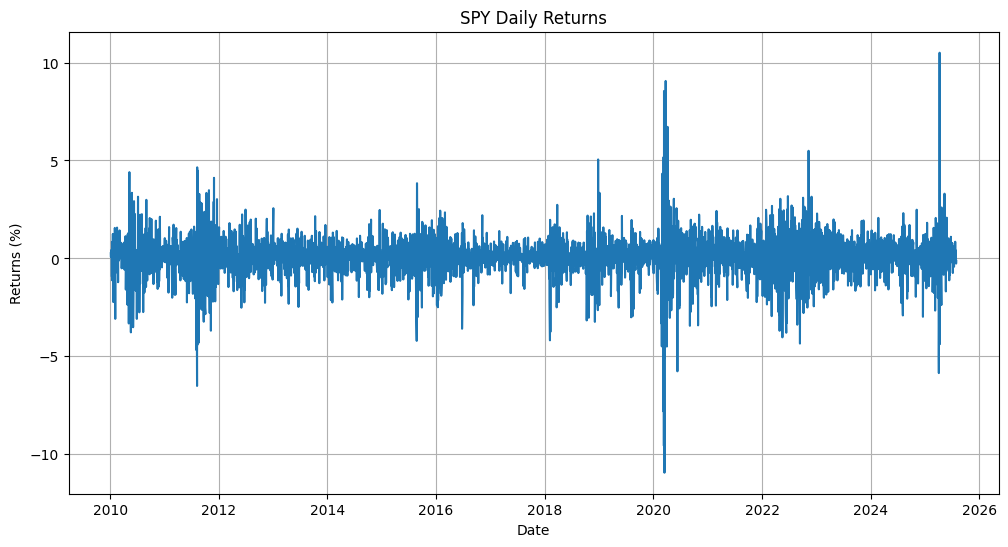

In [5]:
# Calculate logarithmic returns
# GARCH models are typically applied to returns, not raw prices.
# Log returns are often preferred as they are time-additive and more symmetric.
returns = 100 * data['Close'].pct_change().dropna()

# Print a summary of the data
print(f"Data for {ticker} from {start_date} to {end_date}")
print("-" * 50)
print(returns.describe())
print("-" * 50)

# Optional: Plot the returns to visualize volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(returns)
plt.title(f'{ticker} Daily Returns')
plt.ylabel('Returns (%)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# The 'returns' Series is now ready to be used in the next cell for GARCH modeling.